# PROBLEMAS EN LA SELECCIÓN DE CARTERAS


Black and Litterman (1992) señalan que, "cuando los inversores han intentado utilizar modelos cuantitativos para ayudar a optimizar la decisión de asignación crítica, la naturaleza poco razonable de los resultados ha frustrado a menudo sus esfuerzos" (p. 28). Generalmente las ponderaciones que se optienen son extremas (Best y Grauer, 1991), fluctúan sustancialmente a lo largo del tiempo y funcionan mal fuera de la muestra (DeMiguel, Garlappi,and Uppal, 2009). En la práctica nos enfrentamos a este tipo de problemas:

- Extrema sensibilidad de la composición de la varianza ante cambios en las medias, varianzas y covarianzas de los activos.
- Algunos activo no tienen el suficiente número de datos para estimar su correlación con otros activos. 
- Problemas de no estacinariedad.
- Resultados extremos e inestables derivados de los problemas en la esimtación la inversa de la matriz de varianzas y covarianzas.
- Comportamiento de la matriz de varianza en momentos de crisis.
- Evidencia empírica muy controvertida

## 1. Sensibilidad de la composición de la cartera a los cambios en la media, varianza y covarianza de los activos 

Una propiedad deseable de una optimización es que sea robusta frente a pequeños cambios en los parámetros de entrada, y al aprovechar un marco de optimización de carteras debemos asegurarnos de que pequeños cambios en las estimaciones de rentabilidad, volatilidad o correlación no den lugar a carteras fundamentalmente diferentes. Sin embargo, las carteras eficientes son extremadamente sensibles a los cambios en las medias de los activos (Best y Grauer, 1991). Como consecuencia de ello las carteras son especialmente vulnerables a los errores de muestreo en las estimaciones de las medias y covarianzas de los activos (Haugen, 1997). Esto ha dado lugar a una serie de "soluciones" para reducir la influencia del error de muestreo, que van desde restricciones directas y extensivas a las ponderaciones de cartera hasta métodos bayesianos de reducción del tamaño (Jorion, 1985; Forst y Savarino, 1986,1988) a la incorporación de información cualitativa en la construcción de carteras (Black y Littermand, 1992).


### 1.1. Estimación del error en la rentabilidad esperada

En la práctica, los parámetros $\mu$ y $\Sigma$ son desconocidos, es decir, la optimización de la cartera debe llevarse a cabo con incertidumbre sobre los parámetros. Los errores de estimación pueden influir considerablemente en el rendimiento del modelo fuera de la muestra y dar lugar a soluciones muy alejadas de las verdaderas carteras óptimas. Por otro lado si se cumplen las hipótesis básicas del mercado eficiente es prácticamente imposible estimar los rendimientos esperados de los activos a partir de la información pasada. Pero incluso sin considerar los efectos de la eficiencia de mercado, las muestras relativamente pequeñas con las que se suele trabajar, y la falta de experimentos repetibles para aumentar nuestro tamaño de la muestra, puede generar errores significativos en la estimación. Concretamente el error en la estimación de la media es:

$$\epsilon_{mu}=\frac{\sigma}{\sqrt{T}}$$

$\epsilon_{\mu}$ es el error de estimación, $\sigma$ es la volatilidad del activo y $T$ es el número de periodos. 


In [3]:
# Definimos una función para calcular el error de estimación
def emu(sigma, T):
   emu=sigma/(T)**0.5
   return emu

In [4]:
# Disponemos de 20 años de datos, la volatilidad del activo es del 20%
T=20
sigma=0.2
emu(sigma,T)

0.044721359549995794

In [5]:
# Que ocurre si trabajamos con datos mensuales
sigma_m= 0.2/(12)**0.5
T_m=20*12
emu(sigma_m,T_m)

0.00372677996249965

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy as scipy
from datetime import datetime

stocks_list = 'XLB XLF XLK XLP XLV' 
start_date = '2017-09-01'
end_date = '2022-12-01'

df_price = yf.download(tickers=stocks_list, start=start_date,
                   end=end_date, interval="1d")['Adj Close'].dropna()
df_ret = np.log(df_price).diff().dropna()
ret = np.array(df_ret.mean()*252)  # Rendimientos anualizados
cov_mat = np.array(df_ret.cov()*252)  # Matriz de Varianza Covarianza Anualizada

[*********************100%***********************]  5 of 5 completed


In [10]:
def efficient_frontier(ret, cov_mat, N=5000):

    assert len(ret)==len(cov_mat), 'Asegurate que el número de activos utilizados para calcular \
    la rentabilidad coincide con el utilizado para esimar la matriz de varianza-covarianza.'

    # Estimamos las constantes
    n = len(ret)
    a = np.ones(n).T@np.linalg.inv(cov_mat)@ret
    b = ret.T@np.linalg.inv(cov_mat)@ret
    c = np.ones(n).T@np.linalg.inv(cov_mat)@np.ones(n)
    d = b*c-a**2

    # generamos 5000 carteras eficientes 
    ret_arr = np.linspace(0.05,0.2,N)
    vol_arr = np.zeros(N)
    weight_arr = np.zeros((N, len(ret)))
    
    for i in range(N):
        w = 1/d*(c*np.linalg.inv(cov_mat)@ret-a*np.linalg.inv(cov_mat)@np.ones(n))*ret_arr[i] + 1/d*(b*np.linalg.inv(cov_mat)@np.ones(n)-a*np.linalg.inv(cov_mat)@ret)
        vol_arr[i] = np.sqrt(w.T@cov_mat@w)
        weight_arr[i,:] = w

    
    return weight_arr, ret_arr, vol_arr

In [8]:
# Fechas en formato de texto
start_date_str = '2017-09-01'
end_date_str = '2022-12-01'

# Convertir a objetos de fecha
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

# Calcular la diferencia en meses
diff_months = (end_date.year - start_date.year) * 12 + end_date.month - start_date.month
diff_months

63

Consideramos que la rentabilidad de los activos se comporta como una normal, por tanto representamos la frontera eficiente para la rentabilidad media, como para el limite inferior (ci_lower) y superior (ci_upper) del intervalo de confianza de la rentabilidad para nivel de confianza del 90%. Para ello utilizamos `scipy.stats.norm.interval(0.9, loc=ret, scale=sigma_ret)`:

- `scipy.stats.norm`: Se refiere a la distribución normal.
- `interval`: Esta función calcula los límites del intervalo de confianza para la distribución normal.
- `0.9`: Este es el nivel de confianza. En este caso, es del 90%, lo que significa que se espera que el 90% de los valores de la distribución se encuentren dentro de este intervalo.
- `loc=ret`: Este es el parámetro de ubicación (media) de la distribución normal. En estadísticas, loc generalmente se refiere a la media de la distribución. Aquí, ret representaría la rentabilidad esperada o media estimada de una inversión o activo.
- `scale=sigma_ret`: Este es el parámetro de escala (desviación estándar) de la distribución normal. En estadísticas, scale generalmente se refiere a la desviación estándar de la distribución. Aquí, sigma_ret representaría la volatilidad o desviación estándar de la rentabilidad del activo.
ci_lower, ci_upper = ...: La función devuelve dos valores, que son los límites inferior y superior del intervalo de confianza. Estos se asignan a ci_lower (límite inferior del intervalo de confianza) y ci_upper (límite superior del intervalo de confianza), respectivamente.

En resumen, este código calcula el intervalo de confianza del 90% para una distribución normal con una media (ubicación) igual a ret y una desviación estándar (escala) igual a sigma_ret. Esto te dice que, basándote en la distribución normal, hay un 90% de probabilidad de que el verdadero valor de la media (en este caso, la rentabilidad del activo) esté entre ci_lower y ci_upper.

In [11]:
sigma_ret = np.sqrt(np.diag(cov_mat))/np.sqrt(252)
ci_lower, ci_upper = scipy.stats.norm.interval(0.9, loc=ret, scale=sigma_ret)

print(ci_lower, ci_upper)

[0.07200464 0.06566801 0.14348535 0.07398906 0.09976053] [0.12177707 0.12057194 0.20027957 0.10961557 0.13946064]


In [13]:
mean_weight_arr, mean_ret_arr, mean_vol_arr = efficient_frontier(ret, cov_mat )
cil_weight_arr,cil_ret_arr, cil_vol_arr = efficient_frontier(ci_lower, cov_mat )
ciu_weight_arr, ciu_ret_arr, ciu_vol_arr = efficient_frontier(ci_upper, cov_mat )

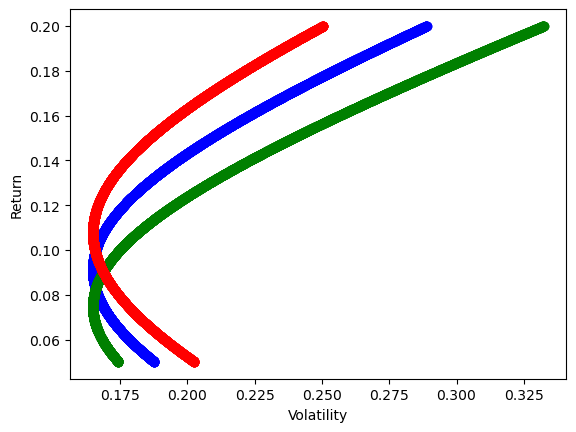

In [14]:
# plot the efficient frontier
plt.scatter(mean_vol_arr, mean_ret_arr, c='blue', label='Mean')
plt.scatter(cil_vol_arr, cil_ret_arr, c='green', label='CI Lower')
plt.scatter(ciu_vol_arr, ciu_ret_arr, c='red', label='CI Upper')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

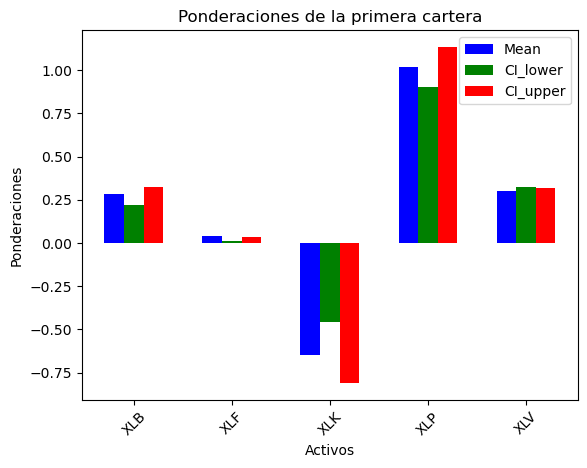

In [15]:
first_portfolio_weights_mean=mean_weight_arr[0]
first_portfolio_weights_cil=cil_weight_arr[0]
first_portfolio_weights_ciu=ciu_weight_arr[0]
stocks = stocks_list.split()

# Configuración del gráfico
bar_width = 0.2  # Ancho de las barras
index = np.arange(len(stocks))  # Los índices de las barras

plt.bar(index, first_portfolio_weights_mean,bar_width, label='Mean',color='blue')
plt.bar(index+ bar_width, first_portfolio_weights_cil,bar_width, label='CI_lower',color='green')
plt.bar(index+ 2*bar_width, first_portfolio_weights_ciu, bar_width, label='CI_upper',color='red')
plt.xlabel('Activos')
plt.ylabel('Ponderaciones')
plt.title('Ponderaciones de la primera cartera')
plt.xticks(rotation=45)  # Rota las etiquetas para mejor legibilidad si son muchas o largas
plt.xticks(index + bar_width, stocks)
plt.legend()
plt.show()

### 1.2. Estimación del error en la varianza estimada

Aunque se hayan estimado los rendimientos medios, sigue existiendo el problema de estimar
la matriz de varianza-covarianza. Con N activos, esta matriz tiene N(N + 1)/2 parámetros.
Así, con 2.000 valores, por ejemplo, hay que estimar más de dos millones de varianzas y covarianzas.

La matriz ofrece una forma intuitiva y clara de entender las interrelaciones entre diferentes activos. Bajo la premisa de que los rendimientos de estos activos se distribuyen de manera normal, la matriz es un estimador de máxima verosimilitud, destacando su eficacia en este contexto teórico. No obstante, es crucial tener en cuenta que cualquier desviación de la normalidad en los rendimientos de los activos puede comprometer la solidez de la matriz de covarianza muestral, limitando su aplicabilidad y precisión en la representación de las dinámicas del mercado.

Disponemos de abundante evidencia empírica sobre la inestabilidad temporal de las varianzas y covarianzas. Esto, junto con la corta historia de algunos activos de interés, limita la posibilidad de estimar los segundos momentos utilizando una muestra histórica larga. Un enfoque alternativo, que la econometría financiera ha explorado intensamente, consiste en aumentar el número de observaciones históricas midiendo los rendimientos con alta frecuencia.

Sin embargo, incluso con T grandes, los datos sugieren a menudo de forma espuria que algunas combinaciones de N activos arriesgados generan carteras casi sin riesgo. Esto puede llevar a crear carteras muy apalancada en un número reducido de títulos que funcione mal fuera de la muestra. Concretamente,  DeMiguel, Garlappi y Uppal (2009) comparan el rendimiento fuera de muestra de las carteras óptimas de media-varianza, estimadas a partir de datos históricos utilizando varios métodos alternativos, y concluyen que en muchas circunstancias, una cartera equiponderada ofrece mejores rendimientos que una cartera eficiente fuera de muestra. 

Es desalentador que incluso los métodos de construcción de carteras que pretenden reducir la dependencia en las varianzas y covarianzas históricas, mediante la introduciendo hipótesis iniciales sobre cómo se espera que se comporten las varianzas y covarianzas de los activos  funcionan relativamente mal.

Lo, Campbell adn Mackinlay (1997) muestran que el error en la estimación de la varianza es:
$$\epsilon_{var}=2\left(\frac{T}{\bigtriangleup_t}-1\right)^{-1} \sigma^2 \tag{2}$$

donde $T$ es el número de periodos, $\bigtriangleup_t$ es la frecuencia en la que la varianza ha sido calculada. El incremento de la frecuencia en la obtención de los datos reduce el error en la estimación de la varianza.

EJEMPLO

## 2. La estimación de la inversa de la matriz de varianzas-covarianzas 

El proceso de optimización requiere estimar la inversa de la matriz de varianza-covarianza.Sin embargo, cuando el número de valores N es del mismo orden de magnitud que el número de periodos T, el número total de parámetros a estimar es del mismo orden que el tamaño total del conjunto de datos, lo cual es claramente problemático. Cuando N es mayor que T la matriz de covarianza de la muestra es singular, es decir no es invertible.

En términos más generales, para $N$ activos, necesitamos periodos de tiempo muy superiores a $N$ para tener una matriz de rango completo. En los casos en que la matriz sea singular, tendremos que recurrir a técnicas de pseudoinversión, que utilizarán técnicas como la descomposición de valores propios o de valores singulares para invertir la matriz de rango bajo de forma estable.

Aún más problemático es que la matriz de covarianza empírica tenga valores propios negativos. Los valores propios negativos no es algo que debería ocurrir de forma natural, ya que implica una varianza negativa para una cartera, lo que claramente no es sensato. Sin embargo, puede ocurrir en la práctica dependiendo de cómo se cree la matriz de covarianza. Por ejemplo, los valores propios negativos pueden ocurrir si utilizamos diferentes ventanas para el cálculo de diferentes términos de covarianza por pares. Si nos encontramos con valores propios negativos, debemos corregirlos antes de invertir la matriz de covarianza.

Ello es crítico cuando se optimizan activos muy correlacionados, y puede dar lugar a carteras inestables e inverosímiles.


Por último, incluso en el caso de una matriz de covarianza con todos los valores propios positivos, la inversión de la matriz de covarianza puede dar lugar a propiedades no deseadas. Esencialmente, si no se hace con cuidado podemos estar amplificando el ruido al invertir la matriz de covarianza.

La descomposición de una matriz de covarianza en valores propios es la siguiente:
$$\Sigma=Q\Lambda Q^T\tag{3}$$

donde $\Lambda$ es una matriz diagonal de autovalores $\lambda_i$ en la diagonal. Además:
$$\Sigma^{-1}=Q\Lambda^{-1} Q^T\tag{4}$$

donde $\Lambda^{-1}$ es la inversa de la $\Lambda$ y los elementos de la diagonal son $\Lambda_{ii}^{-1}=\frac{1}{\lambda_i}$. 

Esto tiene importantes implicaciones para la construcción de carteras eficientes. Es importante recordar que  los valores propios más pequeños adquieren el mayor cuando estimamos la inversa. Esto es problemático porque lo más probable es que los valores propios más pequeños sean ruido. Además, son los valores propios que son estadísticamente indistinguibles de cero en muchos casos. Sin embargo, cuando optimizamos amplificamos estos valores propios insignificantes para que tengan un impacto significativo en la solución. Por ello, se recomienda que, cuando se trabaje con matrices de covarianza en la práctica y se estimen la matriz inversa, los valores propios pequeños se sustituyan por cero y la matriz de bajo rango resultante se trate mediante una operación pseudoinversa, como se ha comentado anteriormente. 


Disponemos de cuatro métodos alternativos a la estimación de la matriz de varianzas covarianza:
1. El modelo de mercado unifactorial: $\sigma_{ij}=\beta_i\beta_j\sigma_m$.
2. El modelo de correlación constante: asume que la correlación entre todos los activos es constante $\sigma_{ij}=\rho \sigma_i \sigma_j$.
3. Los métodos de contracción (shrinkage) asumen que la matriz de varianza-covarianza es una combinación convexa de la varianza-covarianza muestral y una matriz con varianzas en la diagonal y ceros en los demás lugares.
4. Utilizar las opciones para para determinar la desviación típica de los activos.


### 4.1. El modelo de mercado unifactorial

A partir de un índice de mercado podemos estimar las betas de los activos:
####


#### EJEMPLO DE LAS PONDERACIONES EXTREMAS

On the Sensitivity of Mean-Variance-Efficient Portfolios to Changes in Asset Means:
Some Analytical and Computational Results
Michael J. Best
University of Waterloo
Robert R. Grauer
Simon Fraser University



### Sesgo en la estimación de la varianza

La estimación de la media es imprecisa cuando utilizamos periodos cortos de tiempo. Por otro lado, la media no es constante para largos periodos de tiempo. El error que cometemos cuando utilizamos datos históricos para estimar la rentabilidad esparada $\mu=E[\hat{R}]$ es:
$$\epsilon_{\mu}=\frac{\sigma}{\sqrt{T}} \tag{1}$$

donde $\epsilon_{\mu}$ es el error en la estimación, $\sigma$ es la volatilidad del activo y $T$ es la amplitud temporal utilizada para estimar la esperanza.

El error $\epsilon_{\mu}$ representa el error que cometemos al estimar la rentabilidad esperada de un activo financiero utilizando datos históricos. Sugiere que el error en la estimación de la rentabilidad esperada disminuye a medida que aumenta el tamaño de la muestra $T$. Es decir, cuanto más datos históricos tengamos, menor será nuestro error en la estimación de la rentabilidad esperada. Esto se debe a la ley de los grandes números en estadística, que indica que a medida que aumenta el tamaño de la muestra, la media de la muestra tiende a acercarse a la media de la población.

En resumen, esta fórmula nos indica que, aunque podemos usar datos históricos para estimar la rentabilidad esperada de un activo, hay un error inherente en esta estimación que depende de la volatilidad del activo y de la cantidad de datos históricos que utilizamos. Cuanto mayor sea la volatilidad o menor sea la cantidad de datos, mayor será el error en nuestra estimación.

Si disponemos de 20 años de datos, y estimamos la media de un activo con una volatilidad del 20%, el error de estimación de la media es de casi el 4,5%. Sin embargo la rentabilidad media no es estable para periodos largos de tiempo. Habitualmente utilizamos dos métodos para resolver este problema: 
- Estimar funciones que relacionan las características de los activos con sus rendimientos, ya que es probable que las características de las empresas guarden una relación más estable con los rendimientos esperados. 
- Formar carteras de acciones con características similares y, a continuación, estimar los rendimientos medios históricos de esas carteras en lugar utilizar el rendimiento de las acciones individuales.


EJEMPLO

## Singularidad de las matrices de varianzas covarianzas



## La no estacionariedad de las correlaciones de los activos.

La estacionariedad en el contexto de las correlaciones se refiere a la propiedad de que las estadísticas de la serie temporal, como la media y la varianza, permanecen constantes a lo largo del tiempo. Cuando se dice que las correlaciones no son estacionarias, significa que las relaciones de correlación entre diferentes activos financieros cambian con el tiempo. Además las correlaciones tienden a ser más bajas en condiciones de equilibrio y luego se disparan en momentos de tensión en el mercado. 

Si la correlaciones son distintas para diferentes condiciones de mercado, entonces podríamos utilizar una correlación media para el periodo de tiempo completo. Chow, Jacquier y Lowry (1999) proponen la siguiente matriz de covarianza:

$$\Sigma=p\Sigma_s+(1-p) \Sigma_e$$

donde $\Sigma_s$ es la matriz de covarianzas en momentos de stress, $\Sigma_e$ es la matriz de covarianzas en momentos de equilibrio y $p$ e sla probabilidad de entrar en un momento de stress. $p$ puede ser estimada con datos históricos, pero también puede adaptarse a la aversión al riesgo del inversor. Aquellos que presetan una alta aversión al riesgo puede que utilicen altos valores de $p$ para construir su cartera. Podemos utiliza un algortimos de cluster para estimar  $\Sigma_s$ y $\Sigma_e$, para diferenciar los momentos de equilibrio  y de estres.

In financial markets, the correlation between assets changes dynamically, and it is hard to forecast a forward-looking correlation.
The correlation is not linear.

EJEJMPLO DEL CAPitulo 21

## En los momentos de crisis las matriz de varianzas covarianzas cambia significativamente

Un tipo específico de correlación en el riesgo podría ser el riesgo de crédito: en épocas de bonanza, la correlación del riesgo entre activos es baja, mientras que, en épocas de crisis, la correlación se dispara y se mueve en una dirección similar. Véase Credit Risk Pricing, Measurement and Management, de Duffie D. y Singleton, K.J., para un ejemplo de correlación de impago.

Roll y Ross (1994) y Kandel y Stambaugh (1995) muestran que la relación lineal entre la rentabilidad esperada y la beta no es robusta ante una ligera ineficiencia de la cartera de mercado. 


Figura 3: Línea del mercado de los títulos (SML)

![SML](https://raw.githubusercontent.com/alfonso-santos/Python-aplicado-gestion-carteras/fernando/Tema_2/imgs/c10f003.jpg)

Fuente:Brandimarte(2018)


## Falta de datos

El CAPM se puede aplicar cuando invertimos en acciones con precios eficientes y muchos datos. Pero genera problemas con los activos de escasa liquidez, como en el caso de empresas no cotizadas o en empresas de nueva creación, los valores de mercados emergentes. En estos casos carecemos de una visibilidad completa de los precios y muchos se reconstruyen a menudo analíticamente.



## Las limitaciones del CAPM

Si revisamos las hipótesis de partida del CAPM e indentficamos sus desviaciones podremos apreciar la existencia de nuevos factores de riesgo distintos del riesgo de mercado.

1. Los inversores tienen sólo riqueza financiera.
    
    Los inversores no sólo tienen ingresos derivados de sus inversiones financieras y de su actividad profesional sino que además tienen deuda. Si bien los primeros son inciertos, los segundos son fijos. Los ingresos suelen reducirse en etapas de crisis económica y el coste de la deuda incrementarse en con un aumento de la inflación. Por eso dos factores de riesgo tienen que ser el crecimiento económico y la inflación.

    **Leer Jagannathan and Wang (1996) found large improvements in the performance of the CAPM when labor income risk is taken into account**

2. La utilidad de los inversores está basada en el binomio rentabilidad-riesgo
    
    El riesgo suele ser asimétrico ya que el inversor suelen estar más angustiados por las pérdidas que satisfechos por las ganancias, esto genera desviaciones con respecto a las previsiones del CAPM.

- Cuando tratamos con acciones individuales hemos contrastado:
    
    - Existe una prima por riesgo por mayor curtosis tienen una prima de por riesog (Ang, Chen, and Xing 2006)
    
    - Existe una prima por riesgo asociado a los momentos. Es decir, los precios tienen menmoria. 
    
    - Existe una prima de riesgo asociada a la asimetria (Mitton and Vorkink 2007, Boyer,
Mitton, and Vorkink 2010, and Amaya et al. 2012). 

- Cuando tratamos con carteras se ha verficado que existe una prima de riesgo derivada de cómo los rendimientos de las acciones covarian con momentos superiores del mercado.
    
    - Existe una prima por riesgo por co-skewness y co-kurtosis, que resultan del co-movimiento de los rendimientos de las acciones con los momentos de skewness y kurtosis de la cartera de mercado (Harvey and Siddique 2000, Dittmar 2002, Chang, Christoffersen, and Jacobs 2013. 

3. Horizonte temporal de una periodo

    Aunque un horizonte temporal de largo plazo es un supuesto intrascendente para la teoría del CAPM. Debemos tener presentes que si analizamos las carteras en un horizonte temporal dinámico el rebalanceo de carteras esta la estrategia óptima.

4. Los inversores tienen expectativas homogéneas.
    
    Todos los inversores tienen la misma cartera de mercado M. Pero en la realidad cada inversor tiene sus propios segos que generan expectativas heterogéneas lo que puede generar importantes desviaciones con respecto al CAPM. Las creencuas de los inversores pueden ser otro factor de riesgo.
    
5. No existe ni impuestos ni costes de transacción
    
    - No todos los activos tienen una fiscalidd equivalente por tanto debe considerarse que los impuestos son un factor sistemático.
    
    - Los costes de transacción no son homogeneos entre todos los activos, podemos suponer que son mayores para los que presentan menores niveles de liquidez, por ello puede existir un premio por la liquidez.

6. Los inversores son precio aceptantes

    Lamentablemente existen inversores con mejor acceso a la información, si esto tienen acceso a una fuerte cantidad de capital puedne generar desviaciones con respecto al CAPM.

7. La información no tiene costes y esta disponible para todos los inversores.

    Ni la información no tiene coste, ni todas las empresas tienen el mismo nivel de transparencia, por tanto el acceso a la información puede ser considerado un nuevo factor de riesgo (Veldkamp 2011).

In [52]:
def inverse_cov_mat(cov_mat, eps=1e-2, is_plot=True):
    
    w, v = np.linalg.eig(cov_mat)

    # step 1. check if eigenvalues are non-negative 
    assert np.where(w>=0, True, False).sum()==len(w), 'Please ensure the covariance matrix is positive semi-definite.'
    
    # step 2. calculate relative weights and drop small eigenvalues
    weighted_w = w/np.sum(w)
    if is_plot:
        plt.plot(np.sort(w)[::-1], marker='x', label='eigenvalue')
        plt.legend()
        plt.show()
        plt.bar(range(len(w)), np.sort(weighted_w)[::-1], width=0.3, label='relative weight')
        plt.legend()
        plt.show()
        
    w_hat = np.where(weighted_w>=eps, w, 0)
    noise_free_w = w_hat*(np.sum(w)/np.sum(w_hat))

    # step 3. calculate inverse matrix
    inv_mat = v@np.diag(np.where(noise_free_w!=0, 1/noise_free_w, 0))@v.T

    return w, noise_free_w, inv_mat

HACER UN EJEMPLO COMO EL QUE ESTÁ EN EL LIBRO

Sampling Error in Estimates of
Mean-Variance Efficient Portfolio Weights
MARK BRITTEN-JONES (1999)

Un metodología para estimar la eficiencia de mercado. Journal of Finance

Las soluciones

Es importante inlcuir restricciones para dotar de estabilidad a las carteras eficientes. Importante leer este artículo.
Jagannathan and Ma (2003)
https://doi.org/10.1111/1540-6261.00580


Investors can significantly improve estimates of inputs by using robust statistical
estimators. One class of estimators is Bayesian shrinkage methods James and Stein (1961 These
estimators take care of outliers and extreme values that play havoc with traditional
classical estimators.

Covariances can also be shrunk back to a prior where
each stock in an industry, say, has the same volatility and correlation—which is
reasonable if we view each stock in a given industry as similar to the others See Ledoit and Wolf (2003) and Wang (2005), among others. Strictly speaking, the meanvariance
solution involves an inverse of a covariance matrix, sowe should shrink the inverse covariance
rather than the covariance. This is done by Kourtis, Dotsis, and Markellos (2009). Tu and Zhou
(2011) show shrinkage methods can be used to combine naïve and sophisticated diversification
strategies in the presence of estimation risk

Using short data samples to produce estimates for mean-variance inputs is
very dangerous. It leads to pro-cyclicality.When past returns have been high, current
prices are high. But current prices are high because future returns tend to
be low. While predictability in general is very weak, chapter 8 provides evidence
that there is some. Thus, using a past data sample to estimate a mean produces a
high estimate right when future returns are likely to beThese problems are
compounded when more recent data are weighted more heavily, which occurs in
techniques like exponential smoothing. low

An investor using a sample where returns are stable, like the mid-2000s right
before the financial crisis, would produce volatility estimates that are low. But
these times of low volatilities (and high prices) are actually periods when risk is
high.The low estimates of volatilities computed using short samples ending in 2007 totally missed the
explosions in risks that materialized in the 2008–2009 financial crisis.

I believe that asset allocation is fundamentally a valuation problem. The main problem
with using purely historical data, even with the profession’s best econometric
toolkit, is that it usually ignores economic value. Valuation requires an economic framework. Economicmodels could also be combined
with statistical techniques. This is the approach of Black and Litterman
(1991), which is popular because it delivers estimates of expected returns that
are “reasonable” in many situations.An alternative framework for estimating inputs is to work down to the underlying
determinants of value. I will build a case for
thinking about the underlying factors that drive the risk and returns of assets.
Understanding how the factors influence returns and finding which factor exposures
are right for different investors in the long run enables us to construct more
robust portfolios.
The concept of factor investing (see chapter 14), where we look through asset
class labels to the underlying factor risks, is especially important in maximizing
the benefits of diversification.

Jacobs, Müller, andWeber (2010) analyzemore than
5,000 different portfolio construction methods and find that any simple fixedweight
allocation thrashes mean-variance portfolios.

compute variances and correlations using a Bayesian shrinkage estimator
operating on CAPM betas (see Ledoit andWolf (2003)) and estimate expected returns using a variant of Black-Litterman (1991). I set the risk-free rate to be 2%.
I compute mean-variance frontiers constraining the sector weights to be positive

## La evidencia empírica es bastante controvertida

The CAPM has been empirically tested, generating plenty of controversy. Empirical evidence does not fully support the model, although even defining how the test should be carried out is controversial. In fact, we have stated the CAPM in relationship with an index portfolio, but we should actually include any traded asset, not only stock shares, which is far from trivial. Nevertheless, even though we may not believe in the CAPM literally, this does not imply that it is useless. As we shall see in Section 10.3, the CAPM is the foundation of the Black-Litterman portfolio optimization model, which can be interpreted as an application of Bayesian statistics. Furthermore, the CAPM can provide us with a benchmark for security analysis ex-ante, and for performance evaluation ex-post. Let us illustrate how we may use the ex-post SML to evaluate realized performance, taking ex-ante risk into account. The left plot in Fig. 10.3 shows the ex-ante SML. All portfolios p1, p2   and   p3 are on the SML, following the CAPM principle. We may increase the portfolio risk premium only by increasing its exposure to systematic, nondiversifiable risk. The CAPM is about ex-ante expectation, but let us stretch the model a bit and draw the SML ex-post. This means that we plot the actual return performance of each portfolio, while keeping the ex-ante assessment of risk. Let us assume that the market return falls well below its expectation, resulting in a loss. In the picture on the right, the ex-post SML features a negative slope, going through the risk-free asset and the point M' corresponding to the actual market performance. If the observed performance of the three portfolios were in line, the corresponding points P1, P2, and P3 should lie on the SML. On the contrary, say that we observe points , where return is observed ex-post and risk is assessed ex-ante. Note that this approach is not quite correct, nor theoretically sound, as it is not supported by the CAPM. However, the idea is to use the ex-post SML to define a sensible benchmark. For instance, point p3 corresponds to the benchmark performance of a portfolio, consistent with its exposure to market risk and the realized market performance. Point , corresponding to the actual performance, is above p3. This portfolio did not perform well in absolute terms, but it is above the line. Hence, in terms of relative performance, the portfolio manager did fairly well. The same can be said for portfolio p1 , which looks even better than p3 , whereas portfolio p2 had an unsatisfactory performance, as it lies below the ex-post SML.
